Uncalibrated Model Performance:
Mean Absolute Calibration Error: 0.101

Detailed Calibration Analysis:
Predicted Prob | Actual Positive Rate | Difference
--------------------------------------------------
         0.04 |               0.08 |       0.04
         0.13 |               0.16 |       0.03
         0.24 |               0.25 |       0.01
         0.36 |               0.25 |      -0.11
         0.46 |               0.62 |       0.16
         0.55 |               0.78 |       0.23
         0.66 |               1.00 |       0.34
         0.74 |               0.78 |       0.04
         0.87 |               0.82 |      -0.05
         0.97 |               0.98 |       0.01

Calibrated Model Performance:
Mean Absolute Calibration Error: 0.086

Detailed Calibration Analysis:
Predicted Prob | Actual Positive Rate | Difference
--------------------------------------------------
         0.05 |               0.07 |       0.03
         0.14 |               0.14 |       0.00
         0.24 |

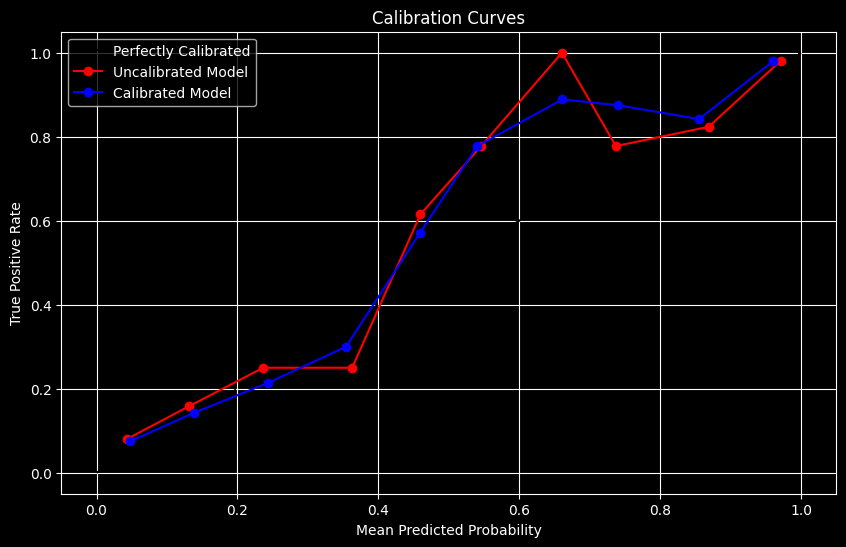

In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt

# Generate sample dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a basic logistic regression model
uncalibrated_model = LogisticRegression(solver='lbfgs')
uncalibrated_model.fit(X_train, y_train)

# Get uncalibrated predictions
uncalibrated_probs = uncalibrated_model.predict_proba(X_test)[:, 1]

# Train a calibrated version using Platt Scaling
calibrated_model = CalibratedClassifierCV(uncalibrated_model, cv=5, method='sigmoid')
calibrated_model.fit(X_train, y_train)

# Get calibrated predictions
calibrated_probs = calibrated_model.predict_proba(X_test)[:, 1]

# Calculate calibration curves
prob_true_uncal, prob_pred_uncal = calibration_curve(y_test, uncalibrated_probs, n_bins=10)
prob_true_cal, prob_pred_cal = calibration_curve(y_test, calibrated_probs, n_bins=10)

# Plot calibration curves
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
plt.plot(prob_pred_uncal, prob_true_uncal, 'ro-', label='Uncalibrated Model')
plt.plot(prob_pred_cal, prob_true_cal, 'bo-', label='Calibrated Model')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('True Positive Rate')
plt.title('Calibration Curves')
plt.legend()
plt.grid(True)

# Function to assess calibration quality
def evaluate_calibration(y_true, y_prob, n_bins=10):
    """
    Evaluate how well-calibrated the model's predictions are
    """
    true_props, pred_props = calibration_curve(y_true, y_prob, n_bins=n_bins)
    
    # Calculate mean absolute calibration error
    calibration_error = np.mean(np.abs(true_props - pred_props))
    
    print(f"Mean Absolute Calibration Error: {calibration_error:.3f}")
    
    # Print detailed bin analysis
    print("\nDetailed Calibration Analysis:")
    print("Predicted Prob | Actual Positive Rate | Difference")
    print("-" * 50)
    for pred, true in zip(pred_props, true_props):
        diff = true - pred
        print(f"{pred:13.2f} | {true:18.2f} | {diff:10.2f}")

# Evaluate both models
print("Uncalibrated Model Performance:")
evaluate_calibration(y_test, uncalibrated_probs)
print("\nCalibrated Model Performance:")
evaluate_calibration(y_test, calibrated_probs)

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

class TemperatureScaling:
    """
    A class to perform temperature scaling for model calibration.
    """
    def __init__(self, device='cpu'):
        self.temperature = nn.Parameter(torch.ones(1).to(device))
        self.device = device

    def forward(self, logits):
        """
        Scale the logits using the temperature parameter
        """
        return logits / self.temperature

    def fit(self, logits, labels, max_iter=50, lr=0.01):
        """
        Find the optimal temperature by minimizing NLL loss
        
        Args:
            logits: Raw predictions from the model (before softmax)
            labels: True labels
            max_iter: Maximum number of optimization iterations
            lr: Learning rate for optimization
        """
        optimizer = optim.LBFGS([self.temperature], lr=lr, max_iter=max_iter)
        
        def eval():
            optimizer.zero_grad()
            scaled_logits = self.forward(logits)
            loss = F.cross_entropy(scaled_logits, labels)
            loss.backward()
            return loss
            
        optimizer.step(eval)
        
        return self

    def calibrate(self, logits):
        """
        Apply temperature scaling to logits
        """
        with torch.no_grad():
            scaled_logits = self.forward(logits)
            return F.softmax(scaled_logits, dim=1)

# Example usage
def demonstrate_temperature_scaling():
    # Create synthetic data
    np.random.seed(42)
    n_samples = 1000
    n_classes = 3
    
    # Generate overconfident logits
    raw_logits = torch.randn(n_samples, n_classes) * 5  # Multiply by 5 to make them overconfident
    true_labels = torch.randint(0, n_classes, (n_samples,))
    
    # Convert to probabilities
    original_probs = F.softmax(raw_logits, dim=1)
    
    # Initialize and fit temperature scaling
    temperature_scaler = TemperatureScaling()
    temperature_scaler.fit(raw_logits, true_labels)
    
    # Get calibrated probabilities
    calibrated_probs = temperature_scaler.calibrate(raw_logits)
    
    # Print results
    print(f"Learned temperature: {temperature_scaler.temperature.item():.3f}")
    
    # Compare confidence distributions
    print("\nConfidence Distribution Analysis:")
    print("Original predictions:")
    print(f"Mean confidence: {original_probs.max(dim=1)[0].mean():.3f}")
    print(f"Max confidence: {original_probs.max(dim=1)[0].max():.3f}")
    print(f"Min confidence: {original_probs.max(dim=1)[0].min():.3f}")
    
    print("\nCalibrated predictions:")
    print(f"Mean confidence: {calibrated_probs.max(dim=1)[0].mean():.3f}")
    print(f"Max confidence: {calibrated_probs.max(dim=1)[0].max():.3f}")
    print(f"Min confidence: {calibrated_probs.max(dim=1)[0].min():.3f}")

    # Function to calculate ECE (Expected Calibration Error)
    def calculate_ece(probs, labels, n_bins=10):
        confidences, predictions = torch.max(probs, dim=1)
        accuracies = predictions.eq(labels)
        
        ece = 0.0
        total_samples = len(confidences)
        
        for bin_lower in torch.linspace(0, 1, n_bins+1)[:-1]:
            bin_upper = bin_lower + 1/n_bins
            bin_mask = (confidences >= bin_lower) & (confidences < bin_upper)
            if bin_mask.any():
                bin_conf = confidences[bin_mask].mean()
                bin_acc = accuracies[bin_mask].float().mean()
                bin_size = bin_mask.sum()
                ece += (bin_size/total_samples) * torch.abs(bin_conf - bin_acc)
        
        return ece.item()
    
    # Calculate and print ECE
    original_ece = calculate_ece(original_probs, true_labels)
    calibrated_ece = calculate_ece(calibrated_probs, true_labels)
    
    print("\nExpected Calibration Error (ECE):")
    print(f"Original model: {original_ece:.3f}")
    print(f"After temperature scaling: {calibrated_ece:.3f}")

# Run the demonstration
demonstrate_temperature_scaling()

Learned temperature: 1.275

Confidence Distribution Analysis:
Original predictions:
Mean confidence: 0.881
Max confidence: 1.000
Min confidence: 0.349

Calibrated predictions:
Mean confidence: 0.852
Max confidence: 1.000
Min confidence: 0.345

Expected Calibration Error (ECE):
Original model: 0.516
After temperature scaling: 0.488


1. Basic Optimization Comparison:
LBFGS result: [0. 0.]
GD result: [5.31227978e-05 5.31227978e-05]
LBFGS iterations: 2
GD iterations: 100

2. Training Neural Network:

Final loss (LBFGS): nan
Final loss (Adam): 0.098059
Training time (LBFGS): 2.75 seconds
Training time (Adam): 0.70 seconds
Number of iterations (LBFGS): 50
Number of iterations (Adam): 1000

3. Memory Usage Analysis:

LBFGS Memory Analysis:
Total parameters: 10201
Parameter memory: 39.85 KB
Gradient history memory: 398.48 KB
Total LBFGS memory: 438.32 KB


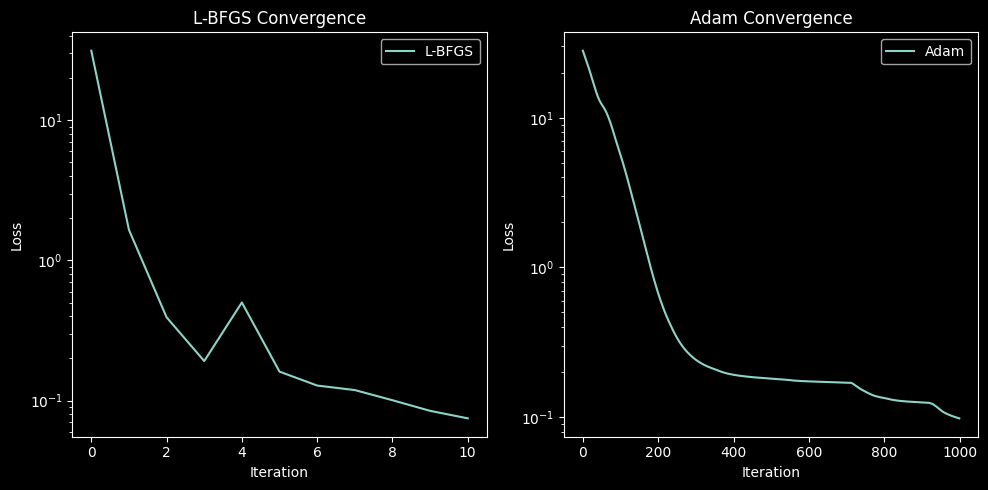

In [4]:
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from time import time

# 1. Simple Example: Comparing LBFGS with SGD
def compare_optimizers():
    # Create a simple quadratic function
    def quadratic_function(x):
        return (x[0]**2 + x[1]**2) / 2

    def quadratic_gradient(x):
        return np.array([x[0], x[1]])

    # Initialize starting point
    x0 = np.array([2.0, 2.0])
    
    # Optimize with LBFGS using scipy
    from scipy.optimize import minimize
    result_lbfgs = minimize(quadratic_function, x0, method='L-BFGS-B', 
                          jac=quadratic_gradient, options={'maxiter': 100})
    
    # Optimize with gradient descent manually
    learning_rate = 0.1
    max_iterations = 100
    x_gd = x0.copy()
    gd_path = [x_gd.copy()]
    
    for _ in range(max_iterations):
        gradient = quadratic_gradient(x_gd)
        x_gd = x_gd - learning_rate * gradient
        gd_path.append(x_gd.copy())
    
    print("LBFGS result:", result_lbfgs.x)
    print("GD result:", x_gd)
    print("LBFGS iterations:", result_lbfgs.nit)
    print("GD iterations:", max_iterations)

# 2. PyTorch Implementation with LBFGS
class ComplexModel(torch.nn.Module):
    def __init__(self):
        super(ComplexModel, self).__init__()
        self.layer1 = torch.nn.Linear(2, 10)
        self.layer2 = torch.nn.Linear(10, 1)
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        return self.layer2(x)

def train_with_different_optimizers():
    # Generate synthetic data with explicit type casting
    np.random.seed(42)
    X = torch.tensor(np.random.randn(100, 2), dtype=torch.float32)
    
    # Calculate target values carefully maintaining float32 dtype
    x0_squared = X[:, 0].pow(2)
    x1_squared = X[:, 1].pow(2)
    random_noise = torch.tensor(np.random.randn(100) * 0.1, dtype=torch.float32)
    y = (3 * x0_squared + 2 * x1_squared + random_noise).reshape(-1, 1)
    
    # Train with LBFGS
    model_lbfgs = ComplexModel()
    optimizer_lbfgs = optim.LBFGS(model_lbfgs.parameters(), lr=0.1, max_iter=20)
    
    def closure():
        optimizer_lbfgs.zero_grad()
        output = model_lbfgs(X)
        loss = torch.nn.MSELoss()(output, y)
        loss.backward()
        return loss
    
    # LBFGS training
    start_time = time()
    losses_lbfgs = []
    
    for i in range(50):
        loss = optimizer_lbfgs.step(closure)
        losses_lbfgs.append(loss.item())
        
    lbfgs_time = time() - start_time
    
    # Train with Adam
    model_adam = ComplexModel()
    optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.01)
    criterion = torch.nn.MSELoss()
    
    start_time = time()
    losses_adam = []
    
    for i in range(1000):  # Adam typically needs more iterations
        optimizer_adam.zero_grad()
        output = model_adam(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer_adam.step()
        losses_adam.append(loss.item())
        
    adam_time = time() - start_time
    
    # Print results
    print(f"\nFinal loss (LBFGS): {losses_lbfgs[-1]:.6f}")
    print(f"Final loss (Adam): {losses_adam[-1]:.6f}")
    print(f"Training time (LBFGS): {lbfgs_time:.2f} seconds")
    print(f"Training time (Adam): {adam_time:.2f} seconds")
    print(f"Number of iterations (LBFGS): {len(losses_lbfgs)}")
    print(f"Number of iterations (Adam): {len(losses_adam)}")
    
    # Plot convergence
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses_lbfgs, label='L-BFGS')
    plt.title('L-BFGS Convergence')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(losses_adam, label='Adam')
    plt.title('Adam Convergence')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
    plt.tight_layout()

# 3. Demonstration of LBFGS memory usage
def demonstrate_memory_usage():
    """
    Demonstrate how LBFGS uses memory to approximate the Hessian
    """
    # Create a model with many parameters
    large_model = torch.nn.Sequential(
        torch.nn.Linear(100, 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, 1)
    )
    
    # Calculate total parameters
    total_params = sum(p.numel() for p in large_model.parameters())
    
    # Calculate approximate memory usage
    history_size = 10  # Default in PyTorch
    param_memory = total_params * 4  # 4 bytes per float32
    gradient_memory = param_memory * history_size
    
    print(f"\nLBFGS Memory Analysis:")
    print(f"Total parameters: {total_params}")
    print(f"Parameter memory: {param_memory / 1024:.2f} KB")
    print(f"Gradient history memory: {gradient_memory / 1024:.2f} KB")
    print(f"Total LBFGS memory: {(param_memory + gradient_memory) / 1024:.2f} KB")

# Run all demonstrations
print("1. Basic Optimization Comparison:")
compare_optimizers()

print("\n2. Training Neural Network:")
train_with_different_optimizers()

print("\n3. Memory Usage Analysis:")
demonstrate_memory_usage()